# Deep Learning with Python
# DL-5-3-2 ConvNet Filters through Gradient Descent

The previous approach of visualizing activations of each filter was an approximate method. It fed a test image as an input to the neural network and the output was the activation of each filter in each layer of the network on that image.

A second approach uses **gradient ascent in the input space** to find the input pattern that will maximise the response of each filter in each layer of the model.

So not only is the process more mathematically rigorous and less subject to chance, it also inverts the process of finding a filter map: we use a filter to derive the optimal image for its activation instead of using images to test the outputs of filters. 

## Summary
- Apply gradient descent to the value of an input image of a convnent to maximise the response of a specific filter.
- Start with a blank input image.
- Use a loss function that maximises the value of a given filter in a convolutional layer. 
- Use SGD to adjust the values of the input image so as to maximise the activation value. 

## Defining Loss Function for Filter Visualization

In [1]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K

In [2]:
# Instantiate a VGG16 model with only the convolutional base
model = VGG16(weights='imagenet', include_top=False)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
# Name of the layer whose filters will be studied
layer_name = 'block3_conv1'

# Index of the filter in the layer
filter_index = 0

In [4]:
# A reference to the output of the chosen convolutional layer
# The output will be a tensor of shape (channels, width, height, filters)
layer_output = model.get_layer(layer_name).output

The loss function in this case is the mean value of all pixels in the filter's activation map. This makes sense because it is a quantitative measure of how much of the filter's pattern was present in the input image: if the input image is an exact match for the pattern encoded by the filter, all the pixels in the filter's output will have a value closer to 255. This is maximal activation.

We will use stochastic gradient descent to derive this pattern by working backwards. 

In [5]:
loss = K.mean(layer_output[:, :, :, filter_index])

## Implementing Gradient Descent

In [6]:
# Using built-in gradients method 
# Returns a list of tensors (of size 1 in this case)
# So indexing the first element
grads = K.gradients(loss, model.input)[0]

Normalize the gradient tensor by dividing it by its L2 norm. This ensures the magnitudes of the updates done to input image are always in the same range, which helps maintain a sense of uniformity in the gradient descrent process.

L2 norm is the RMS?

In [7]:
# Add 1e-5 to divisor to avoid accidnetally dividing by 0
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

## Backend Function `iterate`
Defining our own `keras` backend function called `iterate` that will return the loss value and gradient value as we have defined earlier.

We don't know how it does this: probably a built-in keras routine that finds a mapping between the specified inputs and outputs.

In [8]:
iterate = K.function([model.input], [loss, grads])

In [9]:
import numpy as np

In [10]:
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

## Stochastic Gradient Descent

In [11]:
# Start from a gray image with some random noise
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128

# Magnitude of each gradient update
step = 1.

# Arbitraily implement 40 gradient updates
for i in range(40):
    # Compute the loss and gradient for the given img
    loss_value, grads_value = iterate([input_img_data])
    
    # Adjust input image in the direction that maximises the loss
    input_img_data += grads_value * step
    

## Postprocessing 
We must process the output produced by stochastic gradient descent so that its input tensors can be displayed as images. This means limiting all pixel values to integers between 0 and 255.

In [12]:
def deprocess_image(x):
    x -= x.mean()                     # Mean normalization
    x /= (x.std() + 1e-5)             # STD normalization - avoid div by 0
    x *= 0.1                          # Mean 0, standard deviation of 1
    
    # Clip to [0, 1]
    x += 0.5       
    x = np.clip(x, 0, 1)              
    
    # Convert to RGB Array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    # Return the final image
    return x

## Function for Getting Optimal Pattern for Filter

Combining functionality discussed in the last few cells into a single function that can be called repeatedly for each filter and each layer of a CNN. Will return an image tensor that represents the pattenr that maximises the activation of the specified filter.

In [13]:
def generate_pattern(layer_name, filter_index, size=150):
    # Get a tensor representing the output of the chosen layer
    layer_output = model.get_layer(layer_name).output
    
    # The loss function is the mean value of all pixels
    # in the specified filter for the chosen layer
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # Compute the gradient of the input picture with regard to the loss
    grads = K.gradients(loss, model.input)[0]
    
    # Gradient normalization trick
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Defining backend function return the loss and gradient from the input
    iterate = K.function([model.input], [loss, grads])
    
    # Start with a gray image that has some random noise
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128
    
    # Run 40 gradient descent steps
    step = 1. # floating point, not integer!
    for i in range(40):
        # Get the loss value and gradient for the current value of the image 
        loss_value, grads_value = iterate([input_img_data])
        
        # Move the input_img_data in the direction of the gradient
        input_img_data += grads_value * step
    
    # Normalize and return image as RGB array 
    img = input_img_data[0]
    return deprocess_image(img) 

## Pattern Generation Test

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

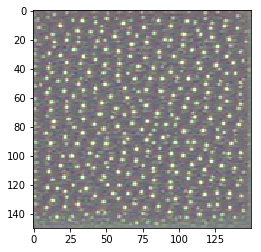

In [29]:
plt.imshow(generate_pattern('block3_conv1', 0))

Filter 0 in the layer `block3_conv1` of this model responds to a polka dot pattern.

## Generating All Activation Maps

Using the `generate_pattern` function to generate optimised activation maps for the first 64 filters for the first convolutional layer in each of the 5 convolutional blocks in the VGG 16's convolutional base.

Because of computational limitations, doing this for the first block as a trial.

In [15]:
layer_names = []
for i in range(1, 6):
    layer_names.append('block' + str(i) + '_conv1')

In [16]:
layer_names

['block1_conv1',
 'block2_conv1',
 'block3_conv1',
 'block4_conv1',
 'block5_conv1']

In [ ]:
for layer_name in layer_names:
    size = 64          # width/height of each activation maps in pixels
    margin = 5         # thickness of margin between adjacent activation maps in grid

    print('Processing Layer ' + layer_name)
    # Results will be an RGB array that stores 64 activation maps in 8 x 8 grid with margins
    # `uint8` is necessary to prevent clipping with 
    results = np.zeros((8 * size + 7 * margin, 
                        8 * size + 7 * margin, 
                        3)).astype('uint8')

    # Iterate over the rows of results grid
    for i in range(8):
        # Iterate over the columns of the results grid
        for j in range(8):
            # Multiplying column index to get the the next filter index
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # Pixel-wise positioning of the filter img in the results array
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size

            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size

            # Append the image to the results array using the right indexing
            results[horizontal_start: horizontal_end, 
                   vertical_start: vertical_end, :] = filter_img
            
        plt.figure(figsize=(20, 20))
        plt.title('Activation Maps - ' + layer_name)
        plt.imshow(results)